# ДЗ №2. Байесовские сети

Всем привет! Сейчас я представлю свое видение сокращенной Байесовской сети, основанной на статье

1. Sien Chen, Wenqiang Huang, Mengxi Chen, Junjiang Zhong, Jie Cheng, Sien Chen, Wenqiang Huang, Mengxi Chen, Junjiang Zhong, and Jie Cheng. 2017. Airlines Content Recommendations Based on Passengers’ Choice Using Bayesian Belief Networks. In Bayesian Inference. IntechOpen. DOI:https://doi.org/10.5772/intechopen.70131


## Предобработка и загрузка данных

Для начала, установим и загрузим необходимые библиотеки

In [ ]:
# Для начала скачаем все необходимые бибиотеки
!pip install pomegranate==0.14.8

!sudo apt update
!sudo apt install libgraphviz-dev -y
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pomegranate import *
from pygraphviz import *

## Построение Сети

Переменные, из которых должна состоять сеть:
- Content Recommendation,
- loyalty,
- age,
- occupation,
- flight time

Т.к. все эти переменные есть в статье, я построю связь прямо как в исследовательском DAG, за исключением переменных, которые мне не предоставлены. Получается:

age -> occupation -> Content Recommendation -> loyalty

flight time -> Content Recommendation

### Переменные без родителей

Переменные без родителей - возраст и время полета

Возраст в оригинале разбивался на 4 категории: до 18, молодые-средние-старые


Т.к. детей младше 18 в данных китайской авиакомпании составляют менее 1% всех пассажиров, я схлопываю их с категорией молодой возраст (YoungAge), остальные веса оставляю как есть


Категории время полета - утро, день и вечер оставляю как есть


In [ ]:
age = DiscreteDistribution({
    'YoungAge': 0.28,
    'MiddleAge': 0.53,
    'Old': 0.19
})

flight_time = DiscreteDistribution({
    'Morning': 0.44,
    'Afternoon': 0.189,
    'Evening': 0.371
})

### Переменные с родителями

occupation (или цель полета) делится на два типа - для досуга и для бизнеса

Логично представить, что среди молодежи и пожилых людей гораздо больше людей, которые едут в путешествия для рекреационных целей, нежели у людей среднего возраста. Люди среднего возраста с большей вероятностью находятся в статусе занятого (работой), а следовательно, летают в бизнес-целях (например, в командировку)

В целом, это доказывать не нужно, но я решил найти ссылку на [статистическое исследование сделанное в США](https://news.gallup.com/poll/388484/air-travel-remains-down-employed-adults-fly-less.aspx), в котором продемонстрировано, что работающие люди совершают больше путевок, нежели неработающие - что соответствует распределению возрастных групп в моих вероятностных весах

In [ ]:
occupation = ConditionalProbabilityTable([
    ['YoungAge', 'Leisure', 0.7],
    ['YoungAge', 'Business', 0.3],
    ['MiddleAge', 'Leisure', 0.6],
    ['MiddleAge', 'Business', 0.4],
    ['Old', 'Leisure', 0.8],
    ['Old', 'Business', 0.2],
], [age])

Дальше идет рассчет вероятностей для той самой рекомендации - всего в оригинальной статье приводится 6 возможных видов рекомендаций контента. Вставлять все их в мою сеть было бы тяжелым занятием, поэтому я оставляю первые 3 (в целом, довольно важные):
- Products: популярные маршруты; международные и внутренние отели; беспошлинные подарки и т.д.;
- Services: специальная помощь, запрос багажа, онлайн-регистрация, предоплаченный багаж и т.д.;
- Tips: путеводитель, развлекательные мероприятия, места в залах ожидания и задержки рейсов


Тк рассчитывать полноценно вероятности через перемножение вероятностей было бы трудно, я решил расставить веса ориентируясь на логику ("экспертное мнение")

Для начала мы должны понять, что для каждой рекомендации контента в сумме должно выходить 1 (products, services, tips)

Итак, в целом в afternoon едет мало людей, поэтому вероятность изначально меньше будет чем во всех остальных категориях

Рекомендательные продукты скорее нужны будут людям, которые едут на досуг, чем тем, кто едет из бизнес-целей

Помощь с сервисом будет актуальнее для людей, которые едут в бизнес-целях, потому что им нужно как можно быстрее выехать из точки А в точку Б. И если у них случается проблема (с багажом, с регистрацией), это сильно влияет по их лояльности

Подсказки вроде путеводителей и популярных мероприятий в точке Б будут значительнее важнее для людей летящих на отдых, очень мала вероятность, что это нужно в бизнес-поездках, имеющих четкую цель

Ориентируясь на логику, описанную сверху, я и распределял веса вручную для разных типов occupation, flight_time, content_recommendation


In [ ]:
# Products, Services, Tips
content_recommendation = ConditionalProbabilityTable(
                [[ 'Leisure', 'Morning', 'Products', 0.15 ],
                 [ 'Leisure', 'Afternoon', 'Products', 0.1 ],
                 [ 'Leisure', 'Evening', 'Products', 0.25 ],
                 [ 'Business', 'Morning', 'Products', 0.25 ],
                 [ 'Business', 'Afternoon', 'Products', 0.1 ],
                 [ 'Business', 'Evening', 'Products', 0.15 ], # total in Products = 1
                 [ 'Leisure', 'Morning', 'Services', 0.125 ],
                 [ 'Leisure', 'Afternoon', 'Services', 0.1 ],
                 [ 'Leisure', 'Evening', 'Services', 0.175 ],
                 [ 'Business', 'Morning', 'Services', 0.3 ],
                 [ 'Business', 'Afternoon', 'Services', 0.1 ],
                 [ 'Business', 'Evening', 'Services', 0.2 ], # total in Services = 1
                 [ 'Leisure', 'Morning', 'Tips', 0.25 ],
                 [ 'Leisure', 'Afternoon', 'Tips', 0.15 ],
                 [ 'Leisure', 'Evening', 'Tips', 0.35 ],
                 [ 'Business', 'Morning', 'Tips', 0.1 ],
                 [ 'Business', 'Afternoon', 'Tips', 0.05 ],
                 [ 'Business', 'Evening', 'Tips', 0.1 ], # total in Tips = 1
], [occupation, flight_time] )

Логика для подсчетов весов лояльности была следующая: скорее всего, самый нужный контент для наших пользователей будет различная помощь с сервисом, что значительно улучшит пользовательских опыт наших пассажиров. Следовательно, для high+services влияние наивысшее.

А tips просто важнее чем продукты, субъективное мнение

In [ ]:
loyalty = ConditionalProbabilityTable([
    ['Products', 'low', 0.25],
    ['Products', 'high', 0.75],
    ['Services', 'low', 0.1],
    ['Services', 'high', 0.9],
    ['Tips', 'low', 0.3],
    ['Tips', 'high', 0.7],
], [content_recommendation])

## Техническая настройка сети

In [ ]:
# Define the network structure
s1 = State(age, name="age")
s2 = State(occupation, name="occupation")
s3 = State(content_recommendation, name="content_recommendation")
s4 = State(loyalty, name="loyalty")
s5 = State(flight_time, name="flight_time")

# Build the Bayesian network
network = BayesianNetwork("Content Recommendation Network")
network.add_states(s1, s2, s3, s4, s5)
network.add_edge(s1, s2)
network.add_edge(s2, s3)
network.add_edge(s3, s4)
network.add_edge(s5, s3)
network.bake()

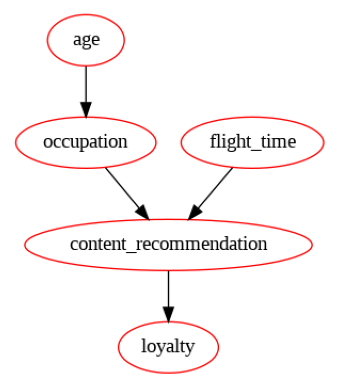

In [ ]:
network.plot()

In [ ]:
network.structure

((), (0,), (1, 4), (2,), ())

## Пример

Итак, не смотря на то что лояльность является конечным node'ом, разумнее всего будет оценить какой контент мы должны выдать пользователю - тк это и является финальной целью той же статьи.

А лояльность зависит уже от того, насколько качественно мы выдали рекомендацию (опять же, это логика исследовательской модели в статье)

Поэтому я попытаюсь предсказать какой контент мы должны посоветовать пользователю, который
- молодой
- летит утром

In [ ]:
evidence = {'age': 'YoungAge', 'flight_time': 'Morning'}
prob_distribution = network.predict_proba(evidence)
s3_index = network.states.index(s3)
print(prob_distribution[s3_index].parameters[0])  # Content Recommendation probabilities

{'Services': 0.3155555555555556, 'Tips': 0.3644444444444444, 'Products': 0.31999999999999995}


Видим, что вероятность Tips выше чем у Services и Products. Поэтому, пользователю, о которым мы знаем такие характеристики (молодой + полет происходит утром) мы должны посоветовать Tips, т.е. путеводитель, развлекательные мероприятия, места в залах ожидания и задержки рейсов
